# Predicting Optimal Challenge Usage

# Part I Modeling Expected Payoff of Successful Challenge

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
win_exp_table=pd.read_csv('WinExp/BigTable-Table 1.csv')

In [3]:
win_exp_table.head()

,Unnamed: 0,Inning,HalfInning,BaseSit,Outs,BaseOuts,InnBaseOut,-15,-14,-13,...,11,12,13,14,15,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42
0,Top,1.0,11.0,1.0,0.0,10.0,1110.0,0.1%,0.2%,0.3%,...,0.0%,0.0%,0.0%,0.0%,0.0%,NaN,NaN,NaN,NaN,NaN
1,Top,1.0,11.0,2.0,0.0,20.0,1120.0,0.1%,0.2%,0.3%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Top,1.0,11.0,3.0,0.0,30.0,1130.0,0.1%,0.1%,0.2%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Top,1.0,11.0,4.0,0.0,40.0,1140.0,0.1%,0.1%,0.2%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Top,1.0,11.0,5.0,0.0,50.0,1150.0,0.1%,0.1%,0.2%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#function takes inning, half, runner on each base, out, run difference and outputs win prob
#call it twice to see result of challenge
def win_exp(inning,half,first,second,third,outs,run_dif):
    sit=int(str(first)+str(second)+str(third),2)+1
    sit_code=str(inning)+str(half)+str(sit)+str(outs)
    return float(win_exp_table[win_exp_table.InnBaseOut==int(sit_code)][str(run_dif)].tolist()[0].strip('%'))/100

# Part II Modeling probability of success of challenge

In [5]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#scrape all replays from 2014 season from mlb.com
mlb14=requests.get('https://baseballsavant.mlb.com/replay?challenge_type=&year=2014&challenger=teamchallenging&team=')

In [7]:
#same for 15
mlb15=requests.get('https://baseballsavant.mlb.com/replay?challenge_type=&year=2015&challenger=teamchallenging&team=')

In [8]:
#same for 16
mlb16=requests.get('https://baseballsavant.mlb.com/replay?challenge_type=&year=2016&challenger=teamchallenging&team=')

In [9]:
#ditto for 17
mlb17=requests.get('https://baseballsavant.mlb.com/replay?challenge_type=&year=2017&challenger=teamchallenging&team=')

In [10]:
#format
data=[BeautifulSoup(season.text) for season in [mlb14,mlb15,mlb16,mlb17]]

/Users/moshelaster/anaconda/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/moshelaster/anaconda/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [11]:
#initialize lists to put data into
num=[]
date=[]
teams=[]
challenger=[]
play_type=[]
overturned=[]
pitcher=[]
batter=[]
inning=[]
description=[]

In [12]:
#iterate through data to place on lists
for season in data:
    for event in season.table.findAll('tr')[1::2]:
        num.append(event.findAll('td')[0].text)
        date.append(event.findAll('td')[1].text)
        teams.append(event.findAll('td')[2].text)
        challenger.append(event.findAll('td')[3].text)
        play_type.append(event.findAll('td')[4].text)
        overturned.append(event.findAll('td')[5].text)
        pitcher.append(event.findAll('td')[6].text)
        batter.append(event.findAll('td')[7].text)
        inning.append(event.findAll('td')[8].text)

    for event in season.table.findAll('tr')[2::2]:
        description.append(event.text)       
        
        
    

In [13]:
#create column names
titles=['num',
'date',
'teams',
'challenger',
'play_type',
'overturned',
'pitcher',
'batter',
'inning',
'description']

In [14]:
#reformat and put into df
challenges=pd.DataFrame(np.matrix([num,
date,
teams,
challenger,
play_type,
overturned,
pitcher,
batter,
inning,description]).T,columns=titles)

In [15]:
#make inning into int
challenges['inning']=pd.to_numeric(challenges['inning'])

In [16]:
#read in text from retrosheet, copied and pasted from http://retrosheet.org/Replay2016.htm and saved locally
ump_stats_head=open('mlbreplay.txt').read().split('\n')[0] #the header
ump_stats=open('mlbreplay.txt').read().split('\n')[1:] #the rest of the data

In [17]:
#wasn't formatted nicely to read in, so figured out spacing 
#inds are simply the indexes that precede a new column
inds=[10,14,18,21,45,65,87,99] 

In [18]:
#copied over header, but inserted commas bf new column
ump_stats_head_fixed=''
for num,char in enumerate(ump_stats_head):
    if num in inds:
        ump_stats_head_fixed+=','
    else:
        ump_stats_head_fixed+=char

In [19]:
#split and stripped each column title
ump_stats_head_fixed=[word.rstrip() for word in ump_stats_head_fixed.split(',')]

In [20]:
#added new column to classify if umpire challenging or manager
ump_stats_head_fixed=ump_stats_head_fixed[:4]+['Init_type']+ump_stats_head_fixed[4:]

In [21]:
#same thing as before except transformed the data into a list of lists of vals
ump_stats_fixed=[]
for line in ump_stats:
    info=''
    for num,char in enumerate(line):
        if num in inds or num==25:
            info+=','
        else:
            info+=char
    ump_stats_fixed.append(map(str.rstrip,info.split(',')))


In [22]:
#read into df
ump_table=pd.DataFrame(ump_stats_fixed,columns=ump_stats_head_fixed)

In [23]:
ump_table.head()

,Date,Tm,Opp,In,Init_type,Initiator,Umpire,Type,Ruling,Time
0,03/31/2014,ATL,MIL,6,Mgr,Fredi Gonzalez,Greg Gibson,Force play,Overturned,1:05
1,03/31/2014,WAS,NYN,10,Mgr,Matt Williams,Clint Fagan,Force play,Confirmed,1:44
2,03/31/2014,CLE,OAK,6,Ump,Mike Winters,Mike Winters,HP collision,Confirmed,1:06
3,03/31/2014,CHN,PIT,5,Mgr,Rich Renteria,Bob Davidson,Force play,Confirmed,1:39
4,03/31/2014,PIT,CHN,10,Mgr,Clint Hurdle,Bob Davidson,Tag play,Overturned,1:46


In [24]:
#stripped out whitespace
for col in ump_table:
    try:
        ump_table[col].apply(lambda x: x.rstrip(),axis=1)
    except:
        pass

In [25]:
#created dictionary to map full name of team to abbreviation, to merge together both datasets
team_abbrev={
    'Giants':'SFN',
    'Angels':'ANA',
    'Astros':'HOU',
    'Athletics':'OAK',
    'Blue Jays':'TOR',
    'Braves':'ATL',
    'Brewers':'MIL',
    'Cardinals':'SLN',
    'Cubs':'CHN',
    'D-backs':'ARI',
    'Dodgers':'LAN',
    'Indians':'CLE',
    'Mariners':'SEA',
    'Marlins':'MIA',
    'Mets':'NYN',
    'Nationals':'WAS',
    'Orioles':'BAL',
    'Padres':'SDN',
    'Phillies':'PHI',
    'Pirates':'PIT',
    'Rangers':'TEX',
    'Rays':'TBA',
    'Red Sox':'BOS',
    'Reds':'CIN',
    'Rockies':'COL',
    'Royals':'KCA',
    'Tigers':'DET',
    'Twins':'MIN',
    'White Sox':'CHA',
    'Yankees':'NYA',
    'Umpire':'UMP',
    'NL':'NL'
    
}

In [26]:
#reverse the dicitonary to enable mapping back and forth
inv_teams = {team_abbr: team for team, team_abbr in team_abbrev.items()}

In [27]:
#make the changes to abbrev.
challenges.challenger=challenges.challenger.apply(lambda x: team_abbrev[x])

In [28]:
ump_table.head()

,Date,Tm,Opp,In,Init_type,Initiator,Umpire,Type,Ruling,Time
0,03/31/2014,ATL,MIL,6,Mgr,Fredi Gonzalez,Greg Gibson,Force play,Overturned,1:05
1,03/31/2014,WAS,NYN,10,Mgr,Matt Williams,Clint Fagan,Force play,Confirmed,1:44
2,03/31/2014,CLE,OAK,6,Ump,Mike Winters,Mike Winters,HP collision,Confirmed,1:06
3,03/31/2014,CHN,PIT,5,Mgr,Rich Renteria,Bob Davidson,Force play,Confirmed,1:39
4,03/31/2014,PIT,CHN,10,Mgr,Clint Hurdle,Bob Davidson,Tag play,Overturned,1:46


In [29]:
#create new column in umpire dataset to impute who challenged call
ump_table['challenger2']=np.where(ump_table['Init_type']=='Ump','UMP',ump_table['Tm'])

In [30]:
#map the play category from one dataset to another
play_dict={
    'catch or drop':'Catch/no catch',
 'fair or foul in outfield':'Fair/foul (outfield)',
 'fan interference':'Fan interference',
 'force play':'Force play',
 'grounds rule':'Grounds rule',
 'hit by pitch':'Hit by pitch',
 'home run':'Home run',
 'home-plate collision':'HP collision',
 'other':'Other',
 'passing runners':'Passing runners',
 'play at 1st':'Force play',
 'record keeping':'Rcd keeping',
 'rules check':'Rules check',
 'slide interference':'Slide rule',
 'stadium boundary call':'Boundary call',
 'tag play':'Tag play',
 'tag-up play':'Tag-up',
 'timing play':'Timing play',
 'touching a base':'Touching a base',
 'trap play':'Trap play (outfield)'
}

In [31]:
challenges.play_type=challenges.play_type.apply(lambda x: play_dict[x])

In [32]:
#change innings to num
ump_table.In=pd.to_numeric(ump_table.In)


In [33]:
#change date to datetime
challenges.date=pd.to_datetime(challenges.date)

In [34]:
ump_table.Date=pd.to_datetime(ump_table.Date)

In [35]:
#eliminates duplicate rows, which were found in mlb.com dataset
challenges=challenges.drop_duplicates(['date','description'])

In [36]:
#modify mlb.com df to drop out the more recent challenges that are not yet recorded by retrosheet
short_challenges=challenges[challenges.date<=sorted(ump_table.Date)[-1]]

In [37]:
#merge both datasets
inner_merge=ump_table.merge(short_challenges,how='inner', left_on=['challenger2','In','Date'], right_on=['challenger','inning','date']).sort_values('Date')

In [38]:
#make day of week variable (based on SABR showing it's predictive)
inner_merge['day']=inner_merge.date.dt.dayofweek

In [39]:
#standardize the play call labels
inner_merge.Ruling=inner_merge.Ruling.apply(lambda x: x.rstrip())

In [40]:
#get rid of retrosheet's 'Rcd keeping' box and default to mlb's ruling (assuming 0=confirmed)
inner_merge['ruling_res']=np.where(inner_merge.Ruling=='Rcd keeping', inner_merge.overturned,inner_merge.Ruling)

In [41]:
#delete the All-Star Game entry
inner_merge = inner_merge[inner_merge.challenger2 != 'NL']

In [42]:
#convert ruling to binary number
inner_merge.ruling_res=inner_merge.ruling_res.apply(lambda x: 'Confirmed' if x==0 else 'Overturned' if x==1 else x)

In [43]:
inner_merge

,Date,Tm,Opp,In,Init_type,Initiator,Umpire,Type,Ruling,Time,...,teams,challenger,play_type,overturned,pitcher,batter,inning,description,day,ruling_res
0,2014-03-31,ATL,MIL,6,Mgr,Fredi Gonzalez,Greg Gibson,Force play,Overturned,1:05,...,Braves ...,ATL,Force play,Yes,Julio Teheran,Ryan Braun,6,\n\n\n\n Braves cha...,0,Overturned
1,2014-03-31,WAS,NYN,10,Mgr,Matt Williams,Clint Fagan,Force play,Confirmed,1:44,...,Nationals ...,WAS,Force play,No,John Lannan,Danny Espinosa,10,\n\n\n\n Nationals ...,0,Confirmed
2,2014-03-31,CLE,OAK,6,Ump,Mike Winters,Mike Winters,HP collision,Confirmed,1:06,...,Indians ...,UMP,HP collision,No,Sonny Gray,Asdrubal Cabrera,6,\n\n\n\n Umpire rev...,0,Confirmed
3,2014-03-31,CHN,PIT,5,Mgr,Rich Renteria,Bob Davidson,Force play,Confirmed,1:39,...,Cubs ...,CHN,Force play,No,Francisco Liriano,Jeff Samardzija,5,\n\n\n\n Cubs chall...,0,Confirmed
4,2014-03-31,PIT,CHN,10,Mgr,Clint Hurdle,Bob Davidson,Tag play,Overturned,1:46,...,Cubs ...,PIT,Tag play,Yes,,,10,\n\n\n\n Pirates ch...,0,Overturned
5,2014-04-01,SFN,ARI,4,Mgr,Bruce Bochy,Chris Guccione,Tag play,Stands,3:19,...,Giants ...,SFN,Tag play,No,,,4,\n\n\n\n Giants cha...,1,Stands
6,2014-04-01,TOR,TBA,7,Ump,Brian Gorman,Jim Wolf,Home run,Stands,3:36,...,Blue Jays ...,UMP,Home run,No,,,7,\n\n\n\n Umpire rev...,1,Stands
7,2014-04-01,TOR,TBA,9,Mgr,John Gibbons,Jim Wolf,Force play,Confirmed,1:20,...,Blue Jays ...,TOR,Force play,No,Jake McGee,Melky Cabrera,9,\n\n\n\n Blue Jays ...,1,Confirmed
8,2014-04-01,TEX,PHI,6,Mgr,Ron Washington,Cory Blaser,Tag play,Overturned,2:18,...,Phillies ...,TEX,Tag play,Yes,,,6,\n\n\n\n Rangers ch...,1,Overturned
15,2014-04-02,PIT,CHN,8,Mgr,Clint Hurdle,Bob Davidson,Hit by pitch,Stands,4:35,...,Cubs ...,PIT,Other,No,,,8,\n\n\n\n Pirates ch...,2,Stands


In [44]:
inner_merge['labels']=inner_merge.overturned.apply(lambda x: 1 if x=='Yes' else 0)

In [45]:
X=inner_merge[['challenger', 'In', 'Umpire', 'day', 'play_type']]
X2=inner_merge[['In','Umpire','day','play_type']]
y=inner_merge[['labels']]

In [46]:
from catboost import CatBoostClassifier, cv, Pool
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import log_loss

In [47]:
x_train, x_test, y_train, y_test =train_test_split(X,y)

In [48]:
x2_train, x2_test, y_train, y_test =train_test_split(X2,y)

In [49]:
ctboost=CatBoostClassifier(loss_function='Logloss',l2_leaf_reg=5,random_seed=123)

In [50]:
ctboost.fit(x_train,y_train,cat_features=[0,1,2,3,4])

In [51]:
log_loss(y_train,ctboost.predict_proba(x_train))

0.68597374872160588

In [52]:
log_loss(y_test,ctboost.predict_proba(x_test))

0.69825967924962828

In [53]:
for i in range(1,10):
    ctboost=CatBoostClassifier(loss_function='Logloss',l2_leaf_reg=i,random_seed=123)
    ctboost.fit(x_train,y_train,cat_features=[0,1,2,3,4])
    print i
    print log_loss(y_train,ctboost.predict_proba(x_train))
    print log_loss(y_test,ctboost.predict_proba(x_test))

1
0.684678577216
0.697925574331
2
0.680274170547
0.698043348444
3
0.679534505564
0.697720445504
4
0.683648640184
0.698697457586
5
0.685973748722
0.69825967925
6
0.685741882247
0.697174984631
7
0.683705665979
0.696858386334
8
0.685524137532
0.696691120706
9
0.686513791335
0.698554574153


In [54]:
ctboost2=CatBoostClassifier(loss_function='Logloss',l2_leaf_reg=5,random_seed=123)

In [55]:
ctboost2.fit(x2_train,y_train,cat_features=[0,1,2,3])

In [56]:
log_loss(y_train,ctboost2.predict_proba(x2_train))

0.60884951507064966

In [57]:
log_loss(y_test,ctboost2.predict_proba(x2_test))

0.62656993062167121

In [58]:
ctboost=CatBoostClassifier(loss_function='Logloss',l2_leaf_reg=5,random_seed=123)
ctboost2=CatBoostClassifier(loss_function='Logloss',l2_leaf_reg=5,random_seed=123)
ctboost.fit(X,y,cat_features=[0,1,2,3,4])
ctboost2.fit(X2,y,cat_features=[0,1,2,3])

Now, the model will output expected probability. Now we have to convert that value taking into consideration that we are modeling on all "challengeable" plays. To model the total number of reasonably "challengeable" plays find the max for any team. To model the total "successes" find the max of successes for any team. (Maybe come back to it, but find the umpire challenges also).

In [59]:
team_games={'ANA': 3,
 'ARI': 0,
 'ATL': 0,
 'BAL': 8,
 'BOS': 3,
 'CHA': 0,
 'CHN': 28,
 'CIN': 0,
 'CLE': 15,
 'COL': 0,
 'DET': 3,
 'HOU': 6,
 'KCA': 31,
 'LAN': 20,
 'MIA': 0,
 'MIL': 0,
 'MIN': 0,
 'NYA': 1,
 'NYN': 15,
 'OAK': 1,
 'PHI': 0,
 'PIT': 2,
 'SDN': 0,
 'SEA': 0,
 'SFN': 21,
 'SLN': 13,
 'TBA': 0,
 'TEX': 8,
 'TOR': 21,
 'UMP': 0,
 'WAS': 9}

In [60]:
three_seasons=162*3*30/2
beg_2017=27*4*30/2
aug2017=12*30/2
playoffs=sum(team_games.values())

In [61]:
total_games=three_seasons+beg_2017+aug2017+playoffs

In [62]:
total_games

9298

In [63]:
#calculate games played per team, 162 for 2 + 106 from 2016 (through 7/31) plus playoffs, ump=6515 from previous summing
inner_merge['games_played']=inner_merge.challenger2.apply(lambda x: 162*3+118+team_games[x] if x!='UMP' else total_games)

In [64]:
#total challenges for a team
inner_merge['tot_challenges']=inner_merge.challenger2.apply(lambda x: len(inner_merge[inner_merge.challenger2==x]))

In [65]:
#divided by total games played
inner_merge['challenge_p_g']=inner_merge.tot_challenges/inner_merge.games_played

In [66]:
#total succesful challenges per team per game
inner_merge['tot_suc']=inner_merge.challenger2.apply(lambda x: len(inner_merge[(inner_merge.challenger2==x)&(inner_merge.overturned=='Yes')]))

In [67]:
#total successful challenges per team per game
inner_merge['tot_suc_p_g']=inner_merge.tot_suc/inner_merge.games_played

In [68]:
#list of challenges only iniatable by umpire
ump_plays=[x for x in inner_merge.play_type.unique() if x not in inner_merge[inner_merge.challenger2!='UMP'].play_type.unique()]

In [69]:
#total umpire initiated challenges
tot_ump_c=len(inner_merge[(inner_merge.play_type.isin(ump_plays)==False)&(inner_merge.challenger2=='UMP')])/2

In [70]:
#total umpire-initiated where overturned
tot_ump_s=len(inner_merge[(inner_merge.play_type.isin(ump_plays)==False)&(inner_merge.challenger2=='UMP')&(inner_merge.overturned=='Yes')])/2

In [71]:
#average umpire issued challenges per game
ucpg=float(tot_ump_c)/total_games

In [72]:
#average umpire overturned per game
uspg=float(tot_ump_s)/total_games

In [73]:
#average team challenge per game
avg_c_p_g=inner_merge[inner_merge.challenger2!='UMP'].groupby('challenger2').challenge_p_g.mean().mean()

In [74]:
#average team success per game
avg_s_p_g=inner_merge[inner_merge.challenger2!='UMP'].groupby('challenger2').tot_suc_p_g.mean().mean()

In [75]:
#approximating "close calls" set by finding most aggressive and most succesfull counts
max_c_p_g=inner_merge.challenge_p_g.unique().max()+ucpg

In [76]:
max_s_p_g=inner_merge.tot_suc_p_g.unique().max()+uspg

In [77]:
#finally, we use conv_f to factor in how much to lower the output of the probability model
conv_f=(max_s_p_g/max_c_p_g)/(avg_s_p_g/avg_c_p_g)

In [78]:
conv_f

0.89255340852778109

# Part III Calculate the "opportunity cost" of a lost challenge

In [79]:
import mlbgame

In [80]:
#winner function inputs a team and date and leverages mlbgame package to output if the team won that game
def winner(challenger,date):
    winner=mlbgame.day(date.year,date.month,date.day,home=inv_teams[challenger],away=inv_teams[challenger])
    if len(winner)<1:
        return 'Wrong Input'
    elif winner[0].w_team==inv_teams[challenger]:
        return 1
    else:
        return 0

In [81]:
inner_merge['won_game']=inner_merge.apply(lambda row: winner(row['Tm'], row['Date']), axis=1)

In [82]:
#finding winning percentage, given lost challenge
winning_pct_lost=inner_merge[(inner_merge.challenger2!='UMP')&(inner_merge.overturned=='No')].won_game.mean()

In [83]:
#finding winning percentage, given won challenge
winning_pct_won=inner_merge[(inner_merge.challenger2!='UMP')&(inner_merge.overturned=='Yes')].won_game.mean()

In [84]:
ocpo=(.5-inner_merge[(inner_merge.challenger2!='UMP')&(inner_merge.overturned=='No')&(inner_merge.inning==1)].won_game.mean())/49

In [85]:
#opportunity cost per out
ocpo

0.00045689917758148053

In [86]:
upper_lim=(.5-winning_pct_lost)/49

In [87]:
upper_lim

0.0012953742138667643

# Testing Model

Inputs needed:
1. Team
2. day
3. umpire
4. play type
5. before challenge
 - Inning
 - Top/Bottom
 - Outs
 - Runners on What base
 - score differential
6. after challenge:
 - Inning
 - Top/Bottom
 - Outs
 - Runners on What base
 - score differential
7. team vs. general variable

In [88]:
#logistic regression with gridsearch
def exp_val(team,day,umpire,play_type,inning1,inning2,half1,half2,outs1,outs2,fb1,fb2,sb1,sb2,tb1,tb2,dif1,dif2,weights=.5,opcost=ocpo):

    #finds the potential gain of an overturned call in WPA
    gain=abs(win_exp(inning2,half2,fb2,sb2,tb2,outs2,dif2)-win_exp(inning1,half1,fb1,sb1,tb1,outs1,dif1))
    
    vec1=pd.Series([team,inning1,umpire,day,play_type]).reshape(1,5)
    vec2=pd.Series([inning1,umpire,day,play_type]).reshape(1,4)
    #generates the probability of success, using team tendency
    prob=ctboost.predict_proba(vec1)[0][1]
    
    #generates the probability of success based on general model
    prob2=ctboost2.predict_proba(vec2)[0][1]*conv_f
    
    #attaches weights to each of the two probabilities
    weighted_prob=weights*prob+(1-weights)*prob2
    
    #multiplies all together to get the expected upside of overturned call
    upside=gain*weighted_prob
    
    #find out how many outs remaining to project downside of call
    if half1==1:
        remaining=(9-inning1)*6+4+3+3-outs1
    else:
        remaining=(9-inning1)*6+4+3-outs1
    
    #downside is number of outs remaining times cost per out
    downside=(1-weighted_prob)*remaining*opcost
    
    return upside-downside

In [89]:
#predict a Mets overturned call, on Tuesday, Joe West umpire, force play at home, 1st inning none on no outs
exp_val('NYN',3,'Joe West','Force play',1,1,1,1,1,0,0,1,0,0,0,0,0,0,0)

/Users/moshelaster/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/moshelaster/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.068266715347986284

In [90]:
test_val=['NYN',3,'Joe West','Force play',1,1,1,1,1,0,0,1,0,0,0,0,0,0]

In [91]:
test_val2='NYN',3,'Joe West','Force play',1,1,1,1,1,0,0,1,0,0,0,0,0

In [92]:
exp_val(*test_val)

/Users/moshelaster/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/moshelaster/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.072653870095026635

In [93]:
def model_viz(team,day,umpire,play_type,inning1,inning2,half1,half2,outs1,outs2,fb1,fb2,sb1,sb2,tb1,tb2,dif1,dif2):
    team_adj=[]
    for i in np.linspace(0,1,11):
        oc_adj=[]
        for j in np.linspace(ocpo,upper_lim,11):
            oc_adj.append(exp_val(team,day,umpire,play_type,inning1,inning2,half1,half2,
                                  outs1,outs2,fb1,fb2,sb1,sb2,tb1,tb2,dif1,dif2,weights=i, opcost=j))
        team_adj.append(oc_adj)
        
    df=pd.DataFrame(team_adj,index=np.linspace(0,1,11))

    htmp=sns.heatmap(df,center=0,annot=True,yticklabels=[str(i*100)[:-2]+'%' for i in np.linspace(0,1,11)])
    htmp.set(xlabel='Opportunity Cost Estimates (lowest to highest)',ylabel='Similarity to Past Challenges')

/Users/moshelaster/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/moshelaster/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


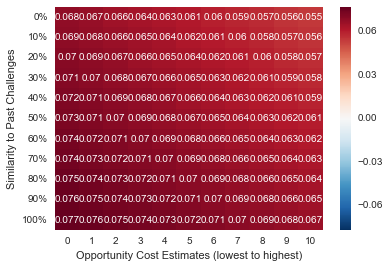

In [94]:
model_viz(*test_val)